# Bagging Regressor
This is a very simple implementation of bagging for regression that can be easily modified for classification. We test it using the Boston Housing dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn

In [2]:
# set the font for plotting and the figure size
font = {'size': 14};
plt.rc('font', **font);
plt.figure(figsize=(8,6));

<Figure size 576x432 with 0 Axes>

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target

In [18]:
def BaggingFit(X,y,base_model,no_models):
    """Fits a bagging regressor using X and y. 
    
        base_model: is the model used
        no_models: is the number of models in the ensemble
        
    """
    
    # number of examples and number of variables
    m,n = X.shape
    
    # array of models, input and output datasets
    models = [ None ] * no_models
    inputs = [ None ] * no_models
    targets = [ None ] * no_models
    
    for i in range(no_models):
        
        # generate the array of bootstrapped examples
        ind = np.floor( m * np.random.rand(m) ).astype(int)
        
        # generate the datasets
        Xi, yi = X[ind,:] , y[ind]
        
        inputs[i] = Xi
        targets[i] = yi
        
        # create a copy of the base model
        model = sklearn.base.clone(base_model)

        # fit the classifier
        model.fit(Xi, yi)
        
        # memorize the model for later prediction
        models[i] = model
        
    # return the array of models
    return models, inputs, targets

The code above is written to be readable and also to return the single dataset used to build every model which might be useful if we wish to do an out-of-bag evaluation.

In [19]:
def baggingFitSimplified(X, base_model, no_models):
    n, m = X.shape
    models = [None] * no_models

    for i in range(no_models):
        ind = np.floor(n * np.random.rand(n)).astype(int)

        model = sklearn.clone(base_model)
        model.fit(X[ind, :], X[ind])
        
        models[i] = model

    return models

In [17]:
f = np.array([[1, 2], [2, 4]])
np.mean(f, axis=0)

array([1.5, 3. ])

In [20]:
def baggindPredict(X, models, use_average=False):
    no_models = len(models)
    predict = np.zeros((X.shape[0], no_models))
    for i in no_models:
        predict[:, i] = models[i].predict(X)
    
    if use_average:
        return np.mean()

In [21]:
def BaggingFitSimplified(X,y,base_model,no_models):
    """Fits a bagging regressor using X and y. 
    
        base_model: is the model used
        no_models: is the number of models in the ensemble
        
        Simplified version that does not store the datasets used
    """
    
    # number of examples and number of variables
    m,n = X.shape

    # array of models, input and output datasets
    models = [ None ] * no_models
    
    for i in range(no_models):
        
        # generate the array of bootstrapped examples
        ind = np.floor( m * np.random.rand(m) ).astype(int)
        
        # create a copy of the base model
        model = sklearn.base.clone(base_model)

        # fit the classifier
        model.fit(X[ind,:] , y[ind])
        
        # memorize the model for later prediction
        models[i] = model
        
    # return the array of models
    return models

In [45]:
def BaggingPredict(models,X,use_average=False):
    no_models = len(models)
    m = X.shape[0]
    predict = np.zeros( (m, no_models) )
    for i in range(no_models):
        predict[:,i] = models[i].predict(X)
    
    if use_average:
        predict = np.mean(predict, axis=1)
    else:
        # Make overall prediction by majority vote
        predict = np.mean(predict, axis=1) > 0 # if +1 vs -1
        
    return predict

First, let's evaluate our implementation. We use the more compact one shown in the slides.

In [46]:
models = BaggingFitSimplified(X, y, DecisionTreeRegressor(max_depth=2), 10)

In [47]:
yp = BaggingPredict(models, X, use_average=True)

In [49]:
print("Performance of Our Bagging Regressor Mean=%.3f"%r2_score(boston.target, yp))

Performance of Our Bagging Regressor Mean=0.769


Next, let's evaluate a single regressor of unlimited depth.

In [37]:
xval_score = cross_val_score(DecisionTreeRegressor(), X, y, cv=KFold(10, shuffle=True, random_state=1234))
print("Single model performance mean=%.3f std=%.3f"%(np.mean(xval_score), np.std(xval_score)))

Single model performance mean=0.717 std=0.163


Finally, let's use the bagging regressor available in Scikit-learn

In [38]:
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=10, random_state=1234)

In [40]:
xval_score = cross_val_score(bagging, X, y, cv=KFold(10,shuffle=True,random_state=1234))
print("Bagging regressor performance mean=%.3f std=%.3f"%(np.mean(xval_score),np.std(xval_score)))

Bagging regressor performance mean=0.716 std=0.083


Note that we did not use crossvalidation with our implementation since it does not follow the fit-predict pattern required by Scikit-learn and thus we would have to implement the procedure ourselves. Also note that bagging results in a much lower standard deviation when compared to a single classifier. 

As a curiosity we can plot all the models computed by our implementation.

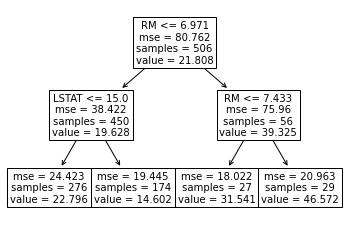

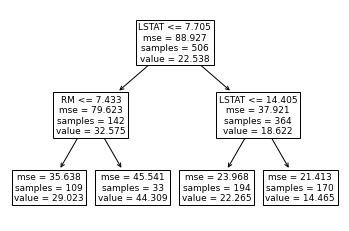

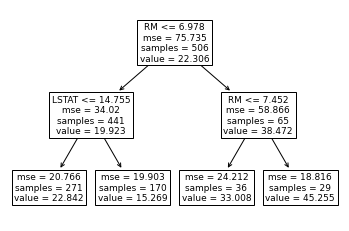

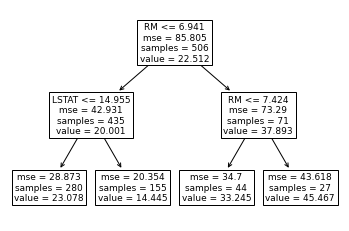

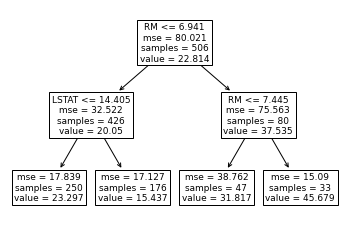

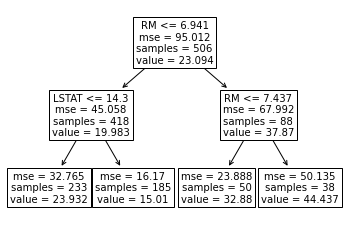

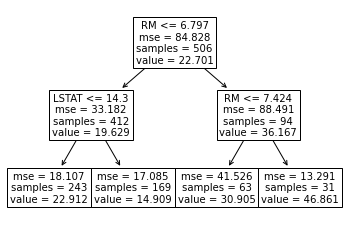

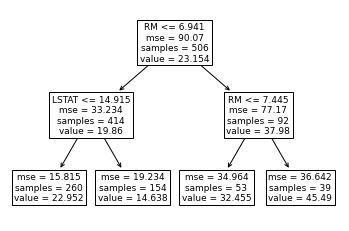

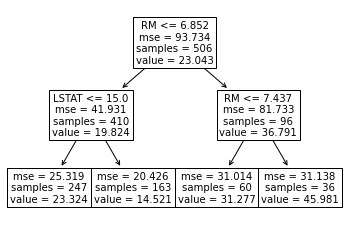

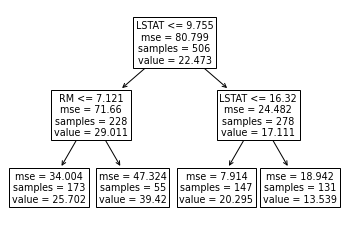

In [33]:
for i in range(len(models)):
    plot_tree(models[i], feature_names=boston.feature_names);
    plt.show() 